### Style Transfer

The Gatys Style Transfer

* From [this very paper](https://arxiv.org/abs/1508.06576)
* Though GAN is better for the task recently, but this style transfer is a good exercise

In [1]:
from torchvision.models.vgg import vgg16
import torch

Replacing all the maxpool to avgpool, drop less info, much more visually pleasing

In [ ]:
def get_avgpool_vgg():
    vgg_model = vgg16(pretrained=True)
    for layer_i in range(len(vgg_model.features)): 
        if type(vgg_model.features[layer_i])==torch.nn.modules.pooling.MaxPool2d:
            vgg_model.features[layer_i] = torch.nn.modules.AvgPool2d(kernel_size=2,stride=2,padding=0,ceil_mode=False)
    return vgg_model

vgg_model = get_avgpool_vgg()

In [4]:
CUDA = torch.cuda.is_available()

from forgebox.ftorch import FG
fg = FG("style_transfer")
p = fg.p

==========hyper params==========
{'height': 180, 'width': 240, 'seqlen_origin': 200, 'epochs_origin': 5, 'epochs_ctt': 5, 'seqlen_ctt': 1000, 'ctt_wgt': 100000.0, 'tv_wgt': 1e-06, 'seqlen_sty': 1000, 'sty_wgt': 1.0, 'epochs_sty': 3, 'tv_sty_wgt': 1.0}


### Check The Model Structure

In [5]:
vgg_model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU(inplace)
  (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

### Establish Learnable Image

In [6]:
from torch import nn
import torch

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [7]:
p("height",210)
p("width",280)

280

In [8]:
if CUDA:
    device = torch.device('cuda')
    def get_img():return nn.Parameter(data = torch.rand(1,p("height"),p("width"),3, requires_grad=True, device=device)).float()
else:
    def get_img():return nn.Parameter(data = torch.rand(1,p("height"),p("width"),3),)
img = get_img()

In [9]:
if CUDA:
    def param_2_npimg(img):
        img_np = img.cpu().data.numpy()
        return np.clip(np.squeeze(img_np,axis=0),0.,1.)
else:
    def param_2_npimg(img):
        img_np = img.data.numpy()
        return np.clip(np.squeeze(img_np,axis=0),0.,1.)

def show_img(img):
    return plt.imshow(param_2_npimg(img))

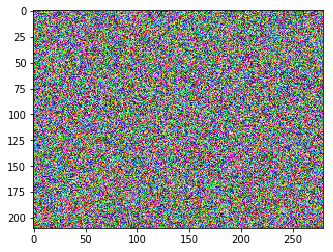

In [10]:
show_img(img)

#### Check Target Image

In [11]:
from PIL import Image

In [12]:
from torch.optim import Adam

In [13]:
from torch.utils.data.dataset import Dataset
class empty(Dataset):
    def __init__(self,length):
        self.length = length
        self.seq = np.random.rand(length,2)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        return self.seq[idx]

In [14]:
from forgebox.ftorch.train import Trainer

In [15]:
mse_func = nn.MSELoss()

In [16]:
def tv_func(y):
    """
    total variation loss function
    return the total variation of an image
    measures how much a pixel varies to its neighbour
    """
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:]))+torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

In [17]:
def torch_shape(img):
    """
    Swap the dimensions for python is bs,h,w,c, but the image we opened is bs,c,h,w
    """
    return img.permute(0,3,1,2)

In [18]:
from pathlib import Path
import os

In [19]:
HOME = Path(os.environ["HOME"])
DATA = HOME/"data"

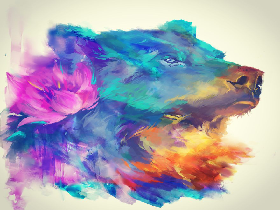

In [20]:
style_img = Image.open(DATA/"style_transfer"/"style"/"indigo_bear.jpg")
style_arr = torch.FloatTensor(np.expand_dims(np.array(style_img.resize((p("width"),p("height")))),axis=0))/255

if CUDA: style_arr = style_arr.cuda()
style_img.resize((p("width"),p("height")))

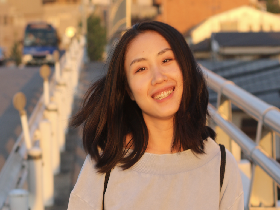

In [21]:
ctt_img = Image.open(DATA/"style_transfer"/"img"/"j_01.png",)
ctt_img = ctt_img.convert('RGB')
ctt_arr = torch.FloatTensor(np.expand_dims(np.array(ctt_img.resize((p("width"),p("height")))),axis=0))/255
if CUDA: ctt_arr = ctt_arr.cuda()
ctt_img.resize((p("width"),p("height")))

In [22]:
def gram(img):
    img = img.squeeze(0)
    return img.bmm(img.permute(0,2,1))

def gram_loss(pred,targ):
    targsize = tuple(targ.size())
    bs,ch,h,w = targsize
    return mse_func(gram(pred),gram(targ))/(ch*h*w)*1e5

#### Style Transfer

Content Reconstruction + Style Reconstruction

In [23]:
con_indices = [6,11,18,25] # for conv_2_1, conv_3_1, conv_4_1, conv_5_1
con_wgt = [0.025,0.275,5.,0.2]
opt = Adam([img],)
trainer = Trainer(empty(p("seqlen_sty",1000)),batch_size=1,shuffle=False, print_on=2)
vgg_feat = vgg_model.features
if CUDA:vgg_feat = vgg_feat.cuda()
    
def calc_ctt_loss(img,ctt_arr,block_idx):
    layer_idx = con_indices[block_idx-1]
    ctt_rep1 = vgg_feat[:layer_idx](torch_shape(img))
    ctt_rep2 = vgg_feat[:layer_idx](torch_shape(ctt_arr)).detach()
    return mse_func(ctt_rep1, ctt_rep2)

@trainer.step_train
def action(*args,**kwargs):
    """
    A training step for noise to learn style
    """
    opt.zero_grad()
    # content
    ctt_loss =  calc_ctt_loss(img,ctt_arr,0)*p("ctt_wgt",1e6) # content loss
    # style
    style_losses = []
    for l in range(len(con_indices)): # for conv_1_1, conv_2_1, conv_3_1, conv_4_1, conv_5_1
        rep1 = vgg_feat[:con_indices[l]](torch_shape(img))
        rep2 = vgg_feat[:con_indices[l]](torch_shape(style_arr)).detach()
        
        style_losses.append(gram_loss(rep1,rep2)*con_wgt[l])
    
    sty_loss = sum(style_losses)
    style_losses = []
    
#     sty_loss*=p("sty_wgt",1) # style loss
    tv_loss = tv_func(torch_shape(img))*p("tv_sty_wgt",1) # total variation loss
    loss = ctt_loss+sty_loss+tv_loss
    
    loss.backward()
    opt.step()
        
    return {"loss":loss.item(),"ctt":ctt_loss.item(),"sty":sty_loss.item(),"tv":tv_loss.item()}

In [ ]:
img = get_img()

In [ ]:
opt = Adam([img],)
trainer.train(p("epochs_sty",3))
show_img(img)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))